# prerocessing

In [18]:
# module, data, feature list loading
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.DtypeWarning)
from functools import partial
from pandarallel import pandarallel
pandarallel.initialize()

# feature and data loading
demo_list = ['age', 'height', 'weight', 'bmi', 'gender']# => race using postponed
vital_list = ['heart_rate', 'resp_rate', 'temperature', 'sbp', 'dbp', 'map', 'paco2', 'pao2', 'fio2']
lab_list = ['gcs', 'bilirubin', 'platelets', 'creatinine', 'lactate', 'bun', 'arterial_ph', 'wbc', 'hemoglobin', 'hematocrit','potassium', 'sodium', 'urine_output']
vaso_list = ['epinephrine', 'dopamine', 'dobutamine', 'norepinephrine', 'phenylephrine', 'vasopressin']
fl_vent_list = ['fluid', 'ventilator']

sofa_list = ['CNS_SOFA', 'CARDIO_SOFA', 'RESP_SOFA', 'COAG_SOFA', 'LIVER_SOFA', 'RENAL_SOFA', 'SOFA']
label_list = ['SEPSIS', 'SHOCK']
core_list = ['sbp', 'dbp', 'map', 'pao2', 'fio2', 'lactate', 'arterial_ph', 'gcs', 'creatinine', 'bilirubin', 'platelets']

tmp = demo_list+vital_list+lab_list+fl_vent_list+vaso_list
tmp = [i+'_value' for i in tmp if i not in ['age', 'bmi', 'gender']]+['age', 'bmi', 'gender']
tmp += [i+'_rate' for i in vaso_list]
tmp += ['SEPSIS', 'vaso_presence']+sofa_list
base_features = tmp.copy()

statistic_features = [i+j for i in core_list for j in ['_min', '_median', '_max', '_presence']]
slope_features = [i+'_slp'+str(j) for i in core_list for j in [1,3,5]]

feature_dict = {}
vaso_fetures = {
    0 : ['SOFA'],
    1 : ['CARDIO_SOFA', 'vaso_presence'],
    2 : [i+'_rate' for i in vaso_list]+[i+'_value' for i in vaso_list]
}
for vaso_lv, fe_lv in [(a, b) for a in [0, 1, 2, 3] for b in [0, 1, 2]]:
    tmp_features = base_features.copy()
    if vaso_lv == 0:
        tmp_features = list(set(tmp_features)-set(vaso_fetures[0]+vaso_fetures[1]+vaso_fetures[2]))
    elif vaso_lv == 1:
        tmp_features = list(set(tmp_features)-set(vaso_fetures[1]+vaso_fetures[2]))
    elif vaso_lv == 2:
        tmp_features = list(set(tmp_features)-set(vaso_fetures[2]))
    
    if fe_lv == 2:
        tmp_features = tmp_features + statistic_features + slope_features
    elif fe_lv == 1:
        tmp_features = tmp_features + statistic_features

    feature_dict[f'vaso{vaso_lv}_fe{fe_lv}'] = tmp_features.copy()

curr_targets = [f'label_pw{a}_tw{b}_ftf{c}'for a in np.arange(1,13) for b in [0, 1, 2, 999] for c in [0, 1]]

icustays = pd.read_csv('processed_data/sepsis/icustays_tab_1hr_v1.csv')
icustays = icustays.loc[icustays.cohort_stays_tab_1hr_v1 == 1].reset_index(drop=True)
stayids = icustays.stay_id.tolist()
shock_ids = icustays[icustays.shock_tab_1hr_v1 == 1].stay_id.tolist()
nonshock_ids = [i for i in stayids if i not in shock_ids]

data = pd.read_csv('sepsis_data_T1FLSv3_df.csv')# with cvp # with age # gender handling
data.gender = np.where(data.gender == 'F', 1, 0)
data.bmi = np.nan_to_num(data.bmi, posinf=0)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [21]:
# dataframe to be used
features = feature_dict[f'vaso{0}_fe{0}']
target = [f'label_pw{8}_tw{999}_ftf{0}']
df = data.loc[:,features+target+['stay_id']].dropna()
n_feats = len(features)

In [22]:
# splits
seed = 2312
df_for_split = pd.DataFrame(columns=['stay_id', 'shock'])
df_for_split['stay_id'] = shock_ids+nonshock_ids
df_for_split['shock'] = [1 for i in range(len(shock_ids))]+[0 for i in range(len(nonshock_ids))]

tmp = df[['stay_id', 'gender']].drop_duplicates()
df_for_split['gender'] = df_for_split['stay_id'].map({a:b for a, b in tmp.values}).copy()

def cohort_split(df, ratios={'trn': 0.7, 'val': 0.1, 'tst':0.2}, seed=seed):
    # sum of ratio should be 1
    _sum = np.sum([ratio for split_label, ratio in ratios.items()])
    if _sum != 1:
        ratios = {split_label:(ratio/_sum) for split_label, ratio in ratios.items()}
        
    # shuffle
    rng = np.random.RandomState(seed)
    idx = df.index.tolist()
    rng.shuffle(idx)
    df = df.loc[idx].reset_index(drop=True)

    # one hot encoding for multi-category columns
    col_names = df.columns
    id_col = [col for col in col_names if col.__contains__('id')]
    strt_cols = [col for col in col_names if col not in id_col]
    one_hot_cols = [col for col in strt_cols if len(df[col].value_counts()) > 1]
    one_hot_df = pd.get_dummies(df[one_hot_cols])
    
    # concat one hot encoded df and original df
    df = pd.concat([df[[col for col in col_names if col not in one_hot_cols]], one_hot_df], axis=1)
    col_names = df.columns
    id_col = [col for col in col_names if col.__contains__('id')]
    strt_cols = [col for col in col_names if col not in id_col]

    df['split'] = None

    # make stratification
    stratifications = df[strt_cols].drop_duplicates().values
    strt_dfs = []
    for strt in stratifications:
        condition = df[strt_cols] == strt
        condition = condition.all(axis=1)
        strt_dfs.append(df.loc[condition].copy())

    # make split
    split_strt_dfs = []
    for strt_df in strt_dfs:
        idx = strt_df.index
        split_sizes = np.round([ratio*len(idx) for split_label, ratio in ratios.items()]).astype(int)
        if any([i==0 for i in split_sizes]):
            raise LookupError("more than one split size is 0. perhaps ratio or stratificed df size are too small")
        else:
            diff = len(idx) - np.sum(split_sizes)
            if diff != 0:
                q = abs(diff)//len(split_sizes)
                r = abs(diff)%len(split_sizes)
                sign = -1 if diff < 0 else 1
                split_sizes += sign*q
                if r !=0 :
                    split_sizes[:r] += sign
        
        strt_df['split'] = [split_label for idx, (split_label, ratio) in enumerate(ratios.items()) for _ in range(split_sizes[idx])]
        split_strt_dfs.append(strt_df)


    splits = pd.concat(split_strt_dfs)

    return splits

df_for_split = cohort_split(df_for_split, {'trn': 0.7, 'val': 0.1, 'tst': 0.2})
trn_ids, val_ids, tst_ids = [df_for_split.query(f'split == "{i}"')['stay_id'] for i in ['trn', 'val', 'tst']]
df_for_split['split'].value_counts()/df_for_split.shape[0]

trn    0.7
tst    0.2
val    0.1
Name: split, dtype: float64

In [23]:
def nrm_std(df, features, split_ids={'trn': trn_ids, 'val': val_ids, 'tst': tst_ids}, nrmorstd='nrm'):
    _df_splits = {a:df.loc[df['stay_id'].isin(b)].copy() for a, b in split_ids.items()}
    if nrmorstd == 'nrm':
        _min = _df_splits['trn'].loc[:, features].min(axis=0)
        _max = _df_splits['trn'].loc[:, features].max(axis=0)
    
        for key in split_ids.keys():
            _df_splits[key].loc[:, features] = (_df_splits[key].loc[:, features] - _min)/(_max - _min + 1e-9)
    elif nrmorstd == 'std':
        _mu = _df_splits['trn'].loc[:, features].mean(axis=0)
        _std = _df_splits['trn'].loc[:, features].std(axis=0)
    
        for key in split_ids.keys():
            _df_splits[key].loc[:, features] = (_df_splits[key].loc[:, features] - _mu)/(_std + 1e-9)
    
    return _df_splits
df_splits = nrm_std(df, features)

In [29]:
df_splits['tst'].reset_index(drop=True).to_csv('mimic_df_septic_shock(tst).csv.gz', compression='gzip')

In [5]:
'''
# length of sequences
seq_lens = df.groupby('stay_id').apply(lambda x: x.shape[0])
max_seq_len = seq_lens.max()

def seq_padding(seq, max_seq_len):
    # self containing
    import pandas as pd 
    import numpy as np
    
    seq_len, n_feats = seq.shape
    minuses = pd.DataFrame(np.zeros(shape=(max_seq_len-seq_len, n_feats)), columns=seq.columns)-1
    padded_seq = pd.concat([seq, minuses], axis=0)
    padded_seq['stay_id'] = padded_seq['stay_id'].iloc[0]
    return padded_seq

for _split_name in tqdm(['trn', 'val', 'tst']):
    df_splits[_split_name] = df_splits[_split_name].groupby('stay_id').parallel_apply(partial(seq_padding, max_seq_len=max_seq_len)).reset_index(drop=True)

'''
print()

In [6]:
def seq_rolling(seq, window):
    # self containing
    import pandas as pd 
    import numpy as np
    
    rolled_seqs = np.array([seq.iloc[i:i+window].to_numpy() for i in range(len(seq)-window+1)])
    if len(rolled_seqs) == 0:
        rolled_seqs = None

    return rolled_seqs

for _split_name in tqdm(['trn', 'val', 'tst']):
    df_splits[_split_name] = df_splits[_split_name].groupby('stay_id').parallel_apply(partial(seq_rolling, window=12)).dropna()

100%|██████████| 3/3 [00:37<00:00, 12.49s/it]


# IMV-LSTM

In [7]:
import torch, gc
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from IPython.display import clear_output
import time

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f'torch version: {torch.__version__}, gpu is available: {torch.cuda.is_available()}')

torch version: 2.0.1+cu117, gpu is available: True


In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = 1
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

## Modeling

In [8]:
class imvt(torch.jit.ScriptModule):
    __constants__ = ['input_dim', 'n_units']
    def __init__(self, input_dim, output_dim, n_units, init_std=0.02):
        super().__init__()
        self.U_j = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_i = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_f = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_o = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.W_j = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_i = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_f = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_o = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.b_j = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_i = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_f = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_o = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.F_alpha_n = nn.Parameter(torch.randn(input_dim, n_units, 1)*init_std)
        self.F_alpha_n_b = nn.Parameter(torch.randn(input_dim, 1)*init_std)
        self.F_beta = nn.Linear(2*n_units, 1)
        self.Phi = nn.Linear(2*n_units, output_dim)
        self.n_units = n_units
        self.input_dim = input_dim
    
    @torch.jit.script_method
    def forward(self, x):
        h_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units).cuda()
        c_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units).cuda()
        outputs = torch.jit.annotate(List[Tensor], [])
        for t in range(x.shape[1]):
            j_tilda_t = torch.tanh(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_j) + \
                                   torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_j) + self.b_j)
            i_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_i) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_i) + self.b_i)
            f_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_f) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_f) + self.b_f)
            o_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_o) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_o) + self.b_o)
            c_tilda_t = c_tilda_t*f_tilda_t + i_tilda_t*j_tilda_t
            h_tilda_t = (o_tilda_t*torch.tanh(c_tilda_t))
            outputs += [h_tilda_t]
        outputs = torch.stack(outputs)
        outputs = outputs.permute(1, 0, 2, 3)
        
        alphas = torch.tanh(torch.einsum("btij,ijk->btik", outputs, self.F_alpha_n)+self.F_alpha_n_b)
        alphas = torch.exp(alphas)
        alphas = alphas/torch.sum(alphas, dim=1, keepdim=True)
        g_n = torch.sum(alphas*outputs, dim=1)
        hg = torch.cat([g_n, h_tilda_t], dim=2)
        mu = self.Phi(hg)
        betas = torch.tanh(self.F_beta(hg))
        betas = torch.exp(betas)
        betas = betas/torch.sum(betas, dim=1, keepdim=True)
        mean = torch.sum(betas*mu, dim=1)

        return mean, alphas, betas

In [9]:
'''
# batch
batch = {_split_name:{} for _split_name in ['trn', 'val', 'tst']}
for _split_name in tqdm(['trn', 'val', 'tst']): 
    
    batch[_split_name]['X'] = df_splits[_split_name].loc[:, features].values.reshape(-1, max_seq_len, len(features))
    batch[_split_name]['y'] = df_splits[_split_name].loc[:, target].values.reshape(-1, max_seq_len, 1)

tensor = {_split_name:{} for _split_name in ['trn', 'val', 'tst']}
tensor['trn']['X'], tensor['val']['X'], tensor['tst']['X'] = [torch.Tensor(batch[_split_name]['X']) for _split_name in ['trn', 'val', 'tst']]
tensor['trn']['y'], tensor['val']['y'], tensor['tst']['y'] = [torch.Tensor(batch[_split_name]['y']) for _split_name in ['trn', 'val', 'tst']]
'''
print()

In [9]:
# batch
tensor = {_split_name:{} for _split_name in ['trn', 'val', 'tst', 'val_nos', 'tst_nos']}
for _split_name in tqdm(['trn', 'val', 'tst', 'val_nos', 'tst_nos']): 
    if _split_name in ['val_nos', 'tst_nos']:
        _tmp_tensor = np.concatenate(df_splits[_split_name[:3]].to_numpy())
        _tmp_tensor = np.array([i for i in _tmp_tensor for w in range(9) if ((i[-w:, -2].sum() == w) & (i[:-w, -2].sum() == 0))])
        tensor[_split_name]['X'] = torch.Tensor(_tmp_tensor[:, :, :-2])
        tensor[_split_name]['y'] = torch.Tensor(_tmp_tensor[:, -1, -2])
    else:
        tensor[_split_name]['X'] = torch.Tensor(np.concatenate(df_splits[_split_name].to_numpy())[:, :, :-2])
        tensor[_split_name]['y'] = torch.Tensor(np.concatenate(df_splits[_split_name].to_numpy())[:, -1, -2])

100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


In [15]:
# hyper parameters
batch_sizes = [100, 128, 200, 256] # [100, 128, 150, 200, 256]
n_hidden_units = [32, 64, 128]
starting_lrs = [0.01, 0.001, 0.0001]

eval_data = []
for bs, n_hu, slr in [(a, b, c) for a in batch_sizes for b in n_hidden_units for c in starting_lrs][:14]:
    loaders = {_split_name:DataLoader(TensorDataset(tensor[_split_name]['X'], tensor[_split_name]['y']), shuffle=True if _split_name=='trn' else False, batch_size=bs) 
                                        for _split_name in ['trn', 'val', 'tst', 'val_nos', 'tst_nos']}
    # model setting
    torch.cuda.manual_seed(seed)
    model = imvt(n_feats, 1, n_hu).cuda()

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=slr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5)
    loss_function = nn.BCELoss()

    # early stopping 
    epochs = 100
    val_losses = [10000]
    early_stopping = {
        'cnt': 0,
        'patience': 3
    }

    gc.collect()
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        loss_train = 0
        print(f'epoch {epoch}: training......')
        st = time.time()
        for batch_x, batch_y in tqdm(loaders['trn']):
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            
            optimizer.zero_grad()
            
            _y_pred, a, b = model(batch_x)
            y_pred = torch.sigmoid(_y_pred.ravel())

            l = loss_function(y_pred, batch_y)
            l.backward()

            loss_train += l.item()

            optimizer.step()

        scheduler.step()
        et = time.time()

        aurocs = {}
        auprcs = {}
        for _split_name, loader in loaders.items():
            if _split_name == 'trn':
                continue

            loss_val = 0
            print('validating and testing')
            with torch.no_grad():
                probs = []
                true = []
                for batch_x, batch_y in tqdm(loader):
                    batch_x = batch_x.cuda()
                    batch_y = batch_y.cuda()
                    _y_pred, a, b = model(batch_x)

                    y_pred = torch.sigmoid(_y_pred.ravel())
                    
                    probs.append(y_pred.cpu().numpy().tolist())
                    true.append(batch_y.detach().cpu().numpy().tolist())
                    loss_val += loss_function(y_pred, batch_y).item()
                    
            probs = np.concatenate(probs)
            true = np.concatenate(true)
            auroc = roc_auc_score(true, probs)
            auprc = average_precision_score(true, probs)
            aurocs[_split_name] = auroc
            auprcs[_split_name] = auprc

        clear_output(wait=True)

        # early stopping?
        if min(val_losses) > loss_val:
            val_losses.append(loss_val)
            print(f'MODEL SAVED at epoch {epoch}')
            torch.save(model.state_dict(), f'models/etc/imvt_seed{seed}_bs{bs}_nhu{n_hu}_slr{slr}.pt')
            early_stopping['cnt'] = 0
        else: 
            early_stopping['cnt'] += 1
            if early_stopping['cnt'] == early_stopping['patience']:
                break
        
        print(f'hyperparameters = batch size:{bs}, hidden units:{n_hu}, learning rate:{slr}')
        print(f'epoch: {epoch:d}, mean trn loss: {loss_train/len(loaders["trn"]):.3f}, mean val loss: {loss_val/len(loaders["val"]):.3f}')
        for _split_name in ['val', 'val_nos', 'tst', 'tst_nos']:
            print(f'{_split_name} auroc: {aurocs[_split_name]:.4f}, {_split_name} auprc: {auprcs[_split_name]:.4f}')

        eval_data.append([bs, n_hu, slr, epoch, et-st, loss_train/len(loaders["trn"]), loss_val/len(loaders["val"])]+
                         [aurocs[_split_name] for _split_name in ['val', 'val_nos', 'tst', 'tst_nos']]+
                         [auprcs[_split_name] for _split_name in ['val', 'val_nos', 'tst', 'tst_nos']])
        
        pd.DataFrame(eval_data, columns=['batch_size', 'n_hidden_units', 'learning_rate', 'epoch', 'time', 'trn_loss', 'val_loss', 
                                        'val_auroc', 'val_nos_auroc', 'tst_auroc', 'tst_nos_auroc', 
                                        'val_auprc', 'val_nos_auprc', 'tst_auprc', 'tst_nos_auprc']).to_csv(f'processed_data/eval_data_imvt_{seed}_b4.csv', index=False)
        
eval_data = pd.DataFrame(eval_data, columns=['batch_size', 'n_hidden_units', 'learning_rate', 'epoch', 'time', 'trn_loss', 'val_loss', 
                                        'val_auroc', 'val_nos_auroc', 'tst_auroc', 'tst_nos_auroc', 
                                        'val_auprc', 'val_nos_auprc', 'tst_auprc', 'tst_nos_auprc'])
eval_data.to_csv(f'processed_data/eval_data_imvt_{seed}_b4.csv', index=False)

hyperparameters = batch size:128, hidden units:64, learning rate:0.001
epoch: 4, mean trn loss: 0.121, mean val loss: 0.139
val auroc: 0.9635, val auprc: 0.7961
val_nos auroc: 0.8498, val_nos auprc: 0.0930
tst auroc: 0.9641, tst auprc: 0.7880
tst_nos auroc: 0.8533, tst_nos auprc: 0.0810
epoch 5: training......


100%|██████████| 12301/12301 [03:20<00:00, 61.32it/s]


validating and testing


100%|██████████| 1816/1816 [00:10<00:00, 176.14it/s]


validating and testing


100%|██████████| 3504/3504 [00:19<00:00, 177.60it/s]


validating and testing


100%|██████████| 1620/1620 [00:09<00:00, 175.47it/s]


validating and testing


100%|██████████| 3147/3147 [00:17<00:00, 176.87it/s]


In [ ]:
'''
# mixed precision training
gc.collect()
torch.cuda.empty_cache()

epochs = 1000
loss_function = nn.CrossEntropyLoss()
patience = 35
min_val_loss = 0.5
counter = 0
scaler = torch.cuda.amp.GradScaler()

for i in range(epochs):
    loss_train = 0

    for batch_x, batch_y in tqdm(trn_loader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        with torch.cuda.amp.autocast():
            y_pred, alphas, betas = model(batch_x)
            l = loss_function(y_pred, batch_y[:,:y_pred.shape[1],:])
            l.to(torch.float16)
            
        scaler.scale(l.to(torch.float16)).backward()
        scaler.step(opt)
        scaler.update()

        loss_train += l.item()*batch_x.shape[0]

    epoch_scheduler.step()

    with torch.no_grad():
        loss_val = 0
        probs = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output
            probs.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            loss_val += loss_function(output, batch_y[:,:output.shape[1],:]).item()*batch_x.shape[0]
    probs = np.concatenate(probs)
    true = np.concatenate(true)
    
    if min_val_loss > loss_val:
        min_val_loss = loss_val
        print("Saving...")
        torch.save(model.state_dict(), f"imv_tensor_lstm_{seed}.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train_loss: ", (loss_train/len(tsr_trn_X)), "val_loss: ", (loss_val/len(tsr_val_X)))
    if(i % 10 == 0):
        auroc = roc_auc_score(true, probs)
        auprc = average_precision_score(true, probs)
        print("lr: ", opt.param_groups[0]["lr"])
        print("auroc: ", auroc, "auprc: ", auprc)
'''
print()

In [16]:
eval_data

,batch_size,n_hidden_units,learning_rate,epoch,time,trn_loss,val_loss,val_auroc,val_nos_auroc,tst_auroc,tst_nos_auroc,val_auprc,val_nos_auprc,tst_auprc,tst_nos_auprc
0,100,32,0.010,0,273.472546,0.177566,0.122364,0.952851,0.828542,0.954109,0.838461,0.746632,0.079063,0.739419,0.071804
1,100,32,0.010,1,261.224326,0.127535,0.139934,0.961966,0.843384,0.964001,0.853700,0.788714,0.099509,0.788051,0.082877
2,100,32,0.010,2,253.869666,0.123968,0.126121,0.962449,0.843548,0.963900,0.849007,0.794222,0.089643,0.795564,0.079810
3,100,32,0.001,0,257.251305,0.157377,0.135924,0.951235,0.831719,0.952880,0.844012,0.731014,0.082794,0.721997,0.070789
4,100,32,0.001,1,256.551878,0.134244,0.137967,0.957854,0.840748,0.958600,0.848923,0.763013,0.084579,0.751595,0.069732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,128,64,0.001,0,200.421504,0.155834,0.125354,0.952147,0.834195,0.952843,0.842172,0.729030,0.080290,0.718946,0.071083
71,128,64,0.001,1,200.664077,0.135718,0.130896,0.956637,0.839295,0.957812,0.849113,0.755199,0.078319,0.748664,0.069122
72,128,64,0.001,2,200.289416,0.127855,0.121049,0.960803,0.845409,0.963012,0.857906,0.777311,0.089102,0.774792,0.080147
73,128,64,0.001,3,200.202776,0.123628,0.123845,0.961991,0.849169,0.963210,0.857844,0.787152,0.091954,0.779585,0.077056


In [ ]:
alphas = pd.DataFrame(alphas, index=features, columns=["t-"+str(i) for i in np.arange(12, 0, -1)]).sort_index()

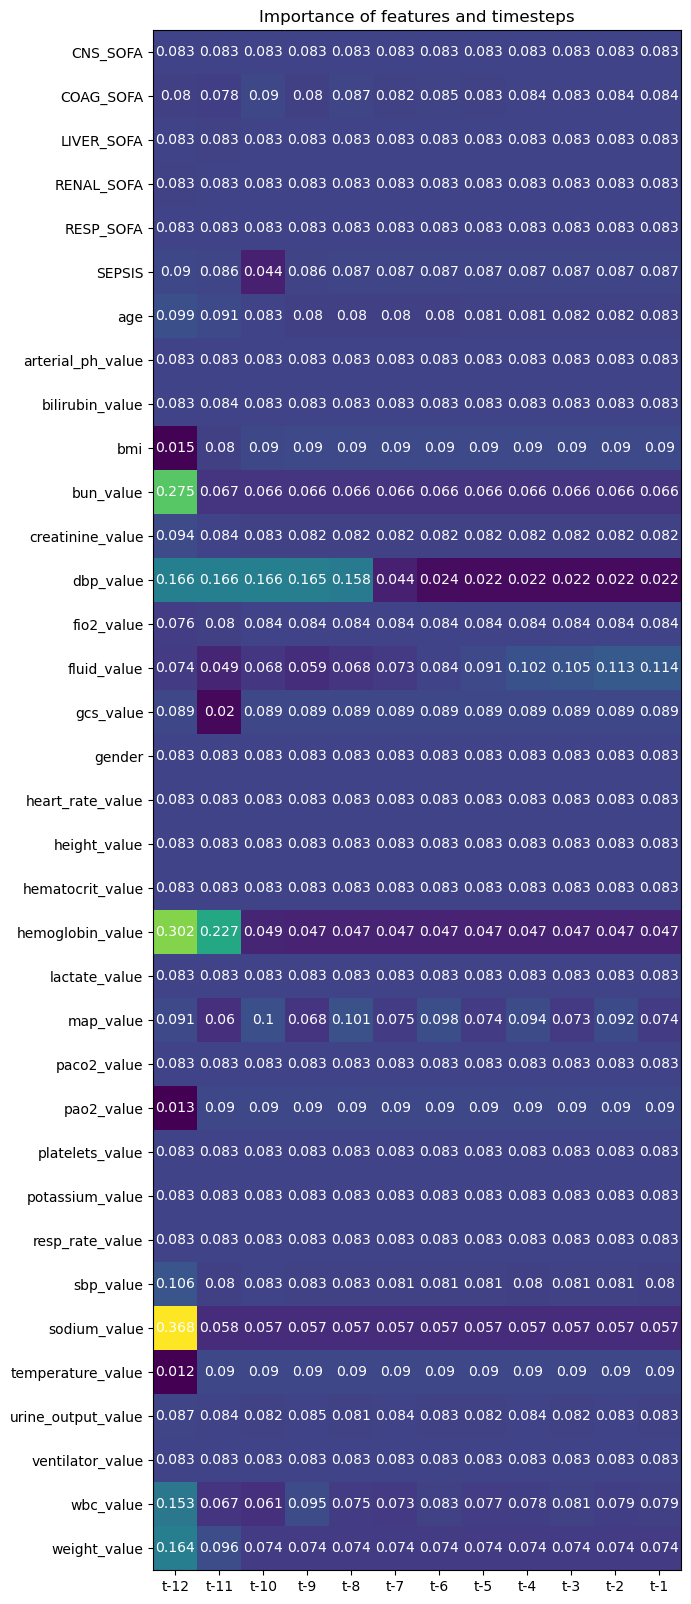

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(12))
ax.set_yticks(np.arange(len(features)))
ax.set_xticklabels(alphas.columns)
ax.set_yticklabels(alphas.index, size=10)
for i in range(len(features)):
    for j in range(12):
        text = ax.text(j, i, round(alphas.values[i, j], 3),
                       ha="center", va="center", color="w", size = 10)
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

In [ ]:
betas = pd.Series((betas-betas.mean())/betas.std(), index=features).sort_values()
betas

SEPSIS               -0.794284
height_value         -0.794284
weight_value         -0.794284
heart_rate_value     -0.794284
gender               -0.794284
paco2_value          -0.794284
pao2_value           -0.794284
temperature_value    -0.794284
bilirubin_value      -0.794284
fio2_value           -0.794284
LIVER_SOFA           -0.794284
bmi                  -0.794284
dbp_value            -0.794282
creatinine_value     -0.794273
CNS_SOFA             -0.794272
sodium_value         -0.793663
potassium_value      -0.791298
COAG_SOFA            -0.786884
hematocrit_value     -0.711917
resp_rate_value      -0.696589
lactate_value        -0.321562
age                   0.060609
RESP_SOFA             0.084212
map_value             0.286844
wbc_value             0.861534
urine_output_value    1.256461
sbp_value             1.462381
fluid_value           1.469958
bun_value             1.495923
RENAL_SOFA            1.505722
gcs_value             1.506320
platelets_value       1.506543
hemoglob

([<matplotlib.axis.XTick at 0x2235ae35730>,
 [Text(0, 0, 'SEPSIS'),
  Text(1, 0, 'height_value'),
  Text(2, 0, 'weight_value'),
  Text(3, 0, 'heart_rate_value'),
  Text(4, 0, 'gender'),
  Text(5, 0, 'paco2_value'),
  Text(6, 0, 'pao2_value'),
  Text(7, 0, 'temperature_value'),
  Text(8, 0, 'bilirubin_value'),
  Text(9, 0, 'fio2_value'),
  Text(10, 0, 'LIVER_SOFA'),
  Text(11, 0, 'bmi'),
  Text(12, 0, 'dbp_value'),
  Text(13, 0, 'creatinine_value'),
  Text(14, 0, 'CNS_SOFA'),
  Text(15, 0, 'sodium_value'),
  Text(16, 0, 'potassium_value'),
  Text(17, 0, 'COAG_SOFA'),
  Text(18, 0, 'hematocrit_value'),
  Text(19, 0, 'resp_rate_value'),
  Text(20, 0, 'lactate_value'),
  Text(21, 0, 'age'),
  Text(22, 0, 'RESP_SOFA'),
  Text(23, 0, 'map_value'),
  Text(24, 0, 'wbc_value'),
  Text(25, 0, 'urine_output_value'),
  Text(26, 0, 'sbp_value'),
  Text(27, 0, 'fluid_value'),
  Text(28, 0, 'bun_value'),
  Text(29, 0, 'RENAL_SOFA'),
  Text(30, 0, 'gcs_value'),
  Text(31, 0, 'platelets_value'),
  Text

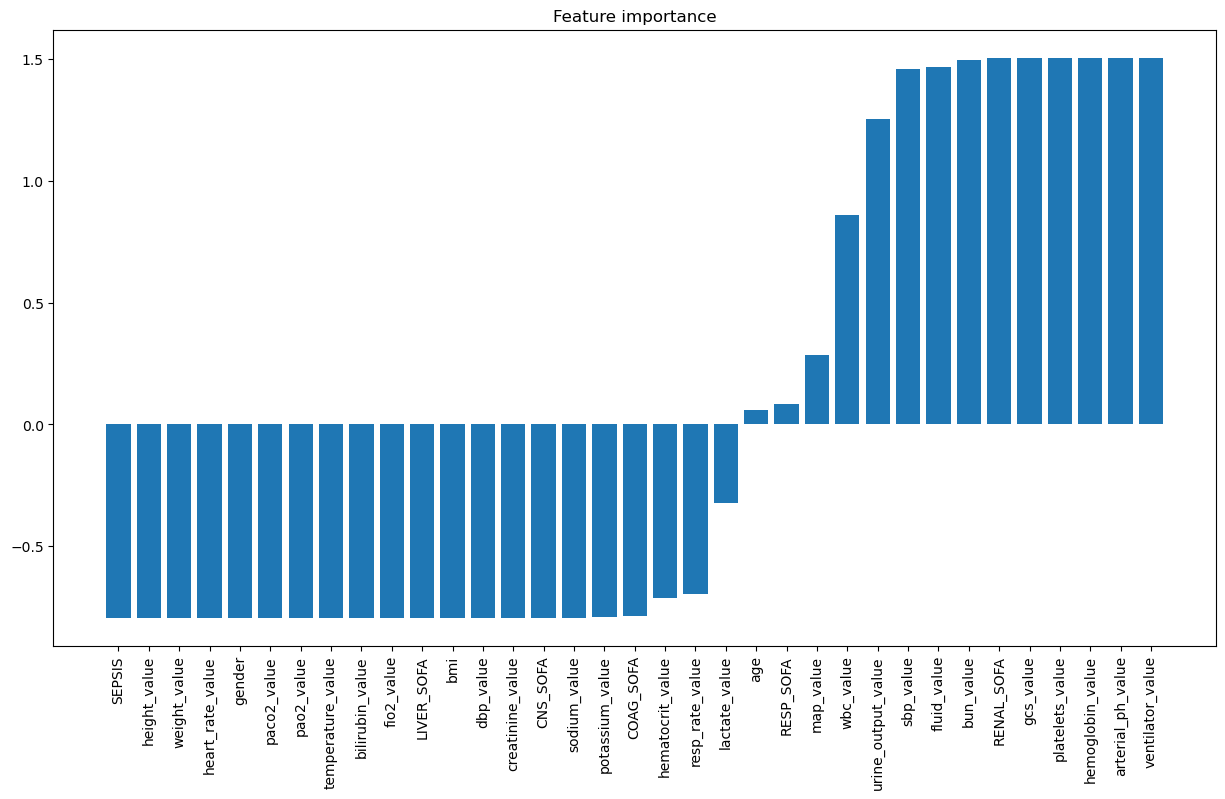

In [ ]:
plt.figure(figsize=(15, 8))
plt.title("Feature importance")
plt.bar(range(len(features)), betas)
plt.xticks(ticks=range(len(features)), labels=betas.index, rotation=90, size=10, fontsize=10)

## Test set performance and interpretation

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.DtypeWarning)
from functools import partial
from pandarallel import pandarallel
pandarallel.initialize()

import torch, gc
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from IPython.display import clear_output
import time

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f'torch version: {torch.__version__}, gpu is available: {torch.cuda.is_available()}')
seed = 2312

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
torch version: 2.0.1+cu117, gpu is available: True


In [15]:
# merging eval_data
tmp = pd.read_csv(f'processed_data/eval_data_imvt_{seed}.csv')
eval_data = pd.concat([pd.read_csv(f'processed_data/eval_data_imvt_{seed}_b4.csv'), tmp]).reset_index(drop=True)
eval_data

,batch_size,n_hidden_units,learning_rate,epoch,time,trn_loss,val_loss,val_auroc,val_nos_auroc,tst_auroc,tst_nos_auroc,val_auprc,val_nos_auprc,tst_auprc,tst_nos_auprc
0,100,32,0.0100,0,273.472546,0.177566,0.122364,0.952851,0.828542,0.954109,0.838461,0.746632,0.079063,0.739419,0.071804
1,100,32,0.0100,1,261.224326,0.127535,0.139934,0.961966,0.843384,0.964001,0.853700,0.788714,0.099509,0.788051,0.082877
2,100,32,0.0100,2,253.869666,0.123968,0.126121,0.962449,0.843548,0.963900,0.849007,0.794222,0.089643,0.795564,0.079810
3,100,32,0.0010,0,257.251305,0.157377,0.135924,0.951235,0.831719,0.952880,0.844012,0.731014,0.082794,0.721997,0.070789
4,100,32,0.0010,1,256.551878,0.134244,0.137967,0.957854,0.840748,0.958600,0.848923,0.763013,0.084579,0.751595,0.069732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,256,128,0.0001,0,127.155100,0.191518,0.143247,0.937743,0.816694,0.939283,0.828131,0.670557,0.070023,0.657307,0.062834
196,256,128,0.0001,1,127.451385,0.151425,0.125135,0.942695,0.819286,0.944779,0.832508,0.697722,0.071768,0.684963,0.064887
197,256,128,0.0001,2,127.249568,0.147216,0.119901,0.943955,0.822252,0.945904,0.835412,0.704726,0.073425,0.691668,0.065225
198,256,128,0.0001,3,127.374118,0.144406,0.130531,0.945494,0.826869,0.946593,0.838027,0.708994,0.074112,0.693723,0.064257


In [16]:
bs, n_hu, slr, _ = eval_data.set_index(['batch_size', 'n_hidden_units', 'learning_rate', 'epoch'])['val_auprc'].idxmax()
print(bs, n_hu, slr)

200 32 0.01


In [17]:
eval_data = eval_data.set_index(['batch_size', 'n_hidden_units', 'learning_rate', 'epoch'])
eval_data.loc[(bs, n_hu, slr)]

C:\Users\KyuminKim\AppData\Local\Temp\ipykernel_22256\1301609085.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  eval_data.loc[(bs, n_hu, slr)]


,time,trn_loss,val_loss,val_auroc,val_nos_auroc,tst_auroc,tst_nos_auroc,val_auprc,val_nos_auprc,tst_auprc,tst_nos_auprc
epoch,,,,,,,,,,,
0,143.358185,0.152983,0.122456,0.957171,0.839540,0.959635,0.852306,0.763091,0.088179,0.760884,0.074899
1,139.233030,0.129383,0.142659,0.959199,0.845245,0.960522,0.858271,0.765303,0.093440,0.759434,0.081401
2,139.080694,0.125338,0.138551,0.939188,0.840278,0.941699,0.848027,0.684830,0.082330,0.677605,0.079365
3,139.035094,0.131427,0.119700,0.961861,0.847265,0.962875,0.855013,0.790865,0.088936,0.782299,0.078215
4,139.253659,0.121555,0.136164,0.964344,0.851771,0.965823,0.859002,0.803710,0.092377,0.798802,0.081344
5,139.317813,0.119399,0.124688,0.964311,0.851936,0.965471,0.858201,0.807840,0.098123,0.800400,0.080854
6,139.570093,0.117893,0.118470,0.963950,0.850275,0.965248,0.859877,0.804077,0.094315,0.797176,0.082927
7,139.191245,0.118251,0.119086,0.960690,0.841684,0.961550,0.850211,0.794139,0.087668,0.784639,0.076750
8,139.367016,0.117226,0.127975,0.964559,0.850278,0.965606,0.857887,0.806782,0.098080,0.798690,0.083148


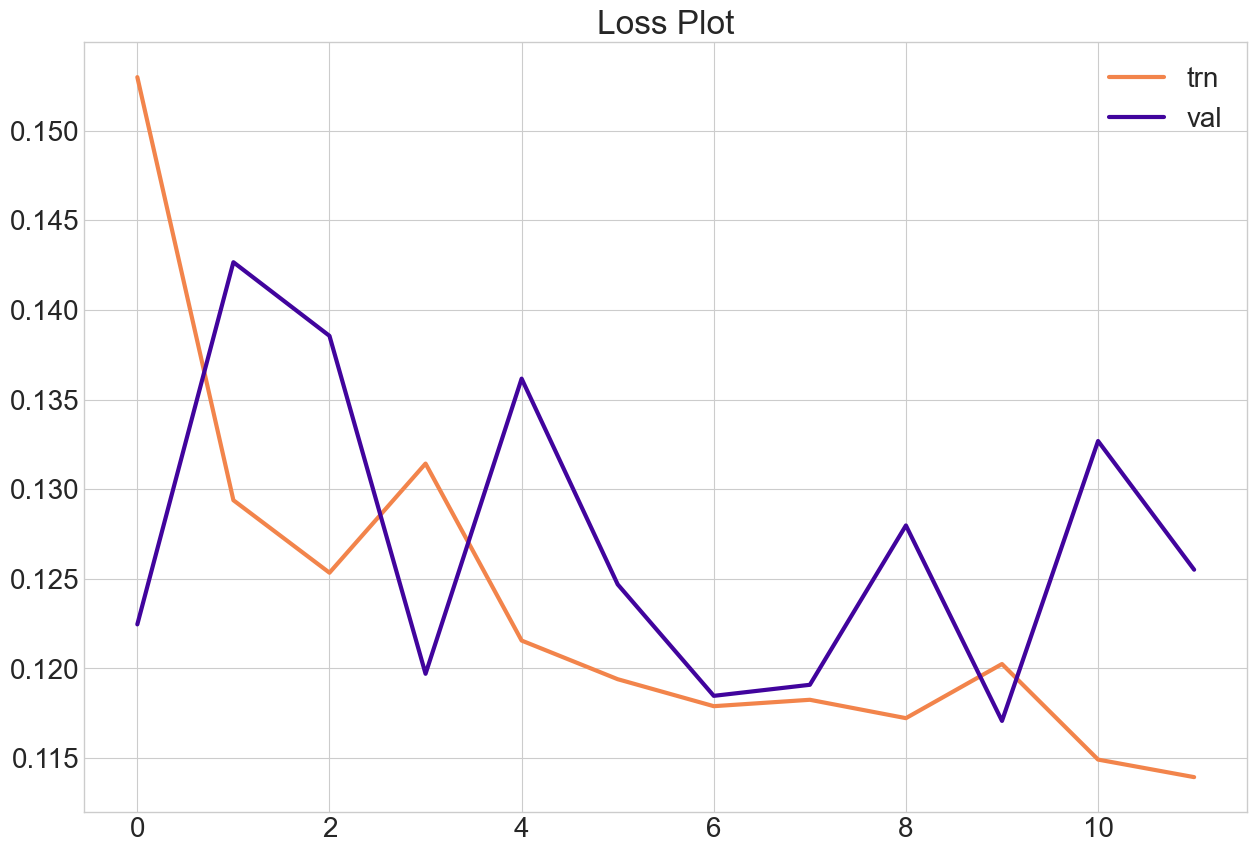

In [7]:
trn_loss = eval_data.query('(batch_size==200) & (n_hidden_units==32) & (learning_rate==0.01)')['trn_loss']
val_loss = eval_data.query('(batch_size==200) & (n_hidden_units==32) & (learning_rate==0.01)')['val_loss']

plt.style.use('seaborn-whitegrid')
cmap_name = 'plasma'
fig = plt.figure(figsize=(15, 10))
plt.rc('font',size=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

ax = fig.add_subplot(1, 1, 1)
ax.plot(range(len(trn_loss)), trn_loss, label='trn', color=plt.cm.get_cmap(cmap_name)(0.7), linewidth=3)
ax.plot(range(len(val_loss)), val_loss, label='val', color=plt.cm.get_cmap(cmap_name)(0.1), linewidth=3)
ax.set_title('Loss Plot')
ax.legend()

In [30]:
# external validation
import gzip
import datatable as dt

with gzip.open('eicu_septic.csv.gz', 'rt') as f:
    tmp = dt.fread(f)
    eICU = tmp.to_pandas()

In [31]:
column_mapping = {
    'patientunitstayid'	: 'stay_id',
    'ABPd': 'dbp_value',
    'ABPs': 'sbp_value',
    'Age': 'age',
    'BUN': 'bun_value',
    'Creatinine': 'creatinine_value',
    'FIO2 (%)': 'fio2_value',
    'GCS_score': 'gcs_value',
    'gender': 'gender',
    'height': 'height_value',
    'pH': 'arterial_ph_value',
    'Total Bilirubin': 'bilirubin_value',
    'Fluids(ml)': 'fluid_value',
    'Sofa_GCS': 'CNS_SOFA',
    'Sofa_Coagulation': 'COAG_SOFA',
    'HR': 'heart_rate_value',
    'Hematocrit': 'hematocrit_value',
    'Hemoglobin': 'hemoglobin_value',
    'Lactate': 'lactate_value',
    'MAP': 'map_value',
    'PaCO2': 'paco2_value',
    'PaO2': 'pao2_value',
    'Platelets': 'platelets_value',
    'Potassium': 'potassium_value',
    'Sofa_Urine': 'RENAL_SOFA',
    'Respiratory Rate': 'resp_rate_value',
    'Sofa_Respiration': 'RESP_SOFA',
    'sepsis': 'SEPSIS',
    'Sodium': 'sodium_value',
    'Urine output': 'urine_output_value',
    'WBC': 'wbc_value',
    'weight': 'weight_value',
    'Sofa_Liver': 'LIVER_SOFA',
    'Temperature': 'temperature_value',
    'Ventilator': 'ventilator_value',
    'Shock_next_12h': 'target'
}

In [32]:
eICU = eICU[list(column_mapping.keys())]

In [33]:
# feature defining
demo_list = ['age', 'height', 'weight', 'bmi', 'gender']# => race using postponed
vital_list = ['heart_rate', 'resp_rate', 'temperature', 'sbp', 'dbp', 'map', 'paco2', 'pao2', 'fio2']
lab_list = ['gcs', 'bilirubin', 'platelets', 'creatinine', 'lactate', 'bun', 'arterial_ph', 'wbc', 'hemoglobin', 'hematocrit','potassium', 'sodium', 'urine_output']
vaso_list = ['epinephrine', 'dopamine', 'dobutamine', 'norepinephrine', 'phenylephrine', 'vasopressin']
fl_vent_list = ['fluid', 'ventilator']

sofa_list = ['CNS_SOFA', 'CARDIO_SOFA', 'RESP_SOFA', 'COAG_SOFA', 'LIVER_SOFA', 'RENAL_SOFA', 'SOFA']
label_list = ['SEPSIS', 'SHOCK']
core_list = ['sbp', 'dbp', 'map', 'pao2', 'fio2', 'lactate', 'arterial_ph', 'gcs', 'creatinine', 'bilirubin', 'platelets']

tmp = demo_list+vital_list+lab_list+fl_vent_list+vaso_list
tmp = [i+'_value' for i in tmp if i not in ['age', 'bmi', 'gender']]+['age', 'bmi', 'gender']
tmp += [i+'_rate' for i in vaso_list]
tmp += ['SEPSIS', 'vaso_presence']+sofa_list
base_features = tmp.copy()

statistic_features = [i+j for i in core_list for j in ['_min', '_median', '_max', '_presence']]
slope_features = [i+'_slp'+str(j) for i in core_list for j in [1,3,5]]

feature_dict = {}
vaso_fetures = {
    0 : ['SOFA'],
    1 : ['CARDIO_SOFA', 'vaso_presence'],
    2 : [i+'_rate' for i in vaso_list]+[i+'_value' for i in vaso_list]
}
for vaso_lv, fe_lv in [(a, b) for a in [0, 1, 2, 3] for b in [0, 1, 2]]:
    tmp_features = base_features.copy()
    if vaso_lv == 0:
        tmp_features = list(set(tmp_features)-set(vaso_fetures[0]+vaso_fetures[1]+vaso_fetures[2]))
    elif vaso_lv == 1:
        tmp_features = list(set(tmp_features)-set(vaso_fetures[1]+vaso_fetures[2]))
    elif vaso_lv == 2:
        tmp_features = list(set(tmp_features)-set(vaso_fetures[2]))
    
    if fe_lv == 2:
        tmp_features = tmp_features + statistic_features + slope_features
    elif fe_lv == 1:
        tmp_features = tmp_features + statistic_features

    feature_dict[f'vaso{vaso_lv}_fe{fe_lv}'] = tmp_features.copy()
# we will use feature_dict[f'vaso{0}_fe{0}']

In [34]:
eICU.columns = eICU.columns.map(column_mapping)
eICU['bmi'] = eICU['weight_value'] / (eICU['height_value']/100).pow(2)
eICU['gender'] = eICU['gender'].map({0:0, 1:1, 2:0})
eICU['bmi'] = np.nan_to_num(eICU['bmi'], posinf=0)
eICU['SEPSIS'] = eICU['SEPSIS'].astype(int)
eICU = eICU[['stay_id']+feature_dict['vaso0_fe0']+['target']]
n_feats = len(feature_dict['vaso0_fe0'])

In [35]:
# normalize
tmp = eICU[feature_dict['vaso0_fe0']].copy()
eICU_max = tmp.max().to_numpy()
eICU_min = tmp.min().to_numpy()

eICU[feature_dict['vaso0_fe0']] = (tmp-eICU_min)/(eICU_max-eICU_min + 1e-9)

In [36]:
eICU.to_csv('eicu_septic_for_extval.csv.gz', compression='gzip')

In [11]:
def seq_rolling(seq, window):
    # self containing
    import pandas as pd 
    import numpy as np
    
    rolled_seqs = np.array([seq.iloc[i:i+window].to_numpy() for i in range(len(seq)-window+1)])
    if len(rolled_seqs) == 0:
        rolled_seqs = None

    return rolled_seqs

roll_seqs = eICU.groupby('stay_id').parallel_apply(partial(seq_rolling, window=12)).dropna()

In [12]:
# dataframe to be used
icustays = pd.read_csv('processed_data/sepsis/icustays_tab_1hr_v1.csv')
icustays = icustays.loc[icustays.cohort_stays_tab_1hr_v1 == 1].reset_index(drop=True)
stayids = icustays.stay_id.tolist()
shock_ids = icustays[icustays.shock_tab_1hr_v1 == 1].stay_id.tolist()
nonshock_ids = [i for i in stayids if i not in shock_ids]

data = pd.read_csv('sepsis_data_T1FLSv3_df.csv')# with cvp # with age # gender handling
data.gender = np.where(data.gender == 'F', 1, 0)
data.bmi = np.nan_to_num(data.bmi, posinf=0)

features = feature_dict[f'vaso{0}_fe{0}']
target = [f'label_pw{8}_tw{999}_ftf{0}']
df = data.loc[:,features+target+['stay_id']].dropna()
n_feats = len(features)

In [13]:
# splits
seed = 2312
df_for_split = pd.DataFrame(columns=['stay_id', 'shock'])
df_for_split['stay_id'] = shock_ids+nonshock_ids
df_for_split['shock'] = [1 for i in range(len(shock_ids))]+[0 for i in range(len(nonshock_ids))]

tmp = df[['stay_id', 'gender']].drop_duplicates()
df_for_split['gender'] = df_for_split['stay_id'].map({a:b for a, b in tmp.values}).copy()

def cohort_split(df, ratios={'trn': 0.7, 'val': 0.1, 'tst':0.2}, seed=seed):
    # sum of ratio should be 1
    _sum = np.sum([ratio for split_label, ratio in ratios.items()])
    if _sum != 1:
        ratios = {split_label:(ratio/_sum) for split_label, ratio in ratios.items()}
        
    # shuffle
    rng = np.random.RandomState(seed)
    idx = df.index.tolist()
    rng.shuffle(idx)
    df = df.loc[idx].reset_index(drop=True)

    # one hot encoding for multi-category columns
    col_names = df.columns
    id_col = [col for col in col_names if col.__contains__('id')]
    strt_cols = [col for col in col_names if col not in id_col]
    one_hot_cols = [col for col in strt_cols if len(df[col].value_counts()) > 1]
    one_hot_df = pd.get_dummies(df[one_hot_cols])
    
    # concat one hot encoded df and original df
    df = pd.concat([df[[col for col in col_names if col not in one_hot_cols]], one_hot_df], axis=1)
    col_names = df.columns
    id_col = [col for col in col_names if col.__contains__('id')]
    strt_cols = [col for col in col_names if col not in id_col]

    df['split'] = None

    # make stratification
    stratifications = df[strt_cols].drop_duplicates().values
    strt_dfs = []
    for strt in stratifications:
        condition = df[strt_cols] == strt
        condition = condition.all(axis=1)
        strt_dfs.append(df.loc[condition].copy())

    # make split
    split_strt_dfs = []
    for strt_df in strt_dfs:
        idx = strt_df.index
        split_sizes = np.round([ratio*len(idx) for split_label, ratio in ratios.items()]).astype(int)
        if any([i==0 for i in split_sizes]):
            raise LookupError("more than one split size is 0. perhaps ratio or stratificed df size are too small")
        else:
            diff = len(idx) - np.sum(split_sizes)
            if diff != 0:
                q = abs(diff)//len(split_sizes)
                r = abs(diff)%len(split_sizes)
                sign = -1 if diff < 0 else 1
                split_sizes += sign*q
                if r !=0 :
                    split_sizes[:r] += sign
        
        strt_df['split'] = [split_label for idx, (split_label, ratio) in enumerate(ratios.items()) for _ in range(split_sizes[idx])]
        split_strt_dfs.append(strt_df)


    splits = pd.concat(split_strt_dfs)

    return splits

df_for_split = cohort_split(df_for_split, {'trn': 0.7, 'val': 0.1, 'tst': 0.2})
trn_ids, val_ids, tst_ids = [df_for_split.query(f'split == "{i}"')['stay_id'] for i in ['trn', 'val', 'tst']]
df_for_split['split'].value_counts()/df_for_split.shape[0]

trn    0.7
tst    0.2
val    0.1
Name: split, dtype: float64

In [14]:
def nrm_std(df, features, split_ids={'trn': trn_ids, 'val': val_ids, 'tst': tst_ids}, nrmorstd='nrm'):
    _df_splits = {a:df.loc[df['stay_id'].isin(b)].copy() for a, b in split_ids.items()}
    if nrmorstd == 'nrm':
        _min = _df_splits['trn'].loc[:, features].min(axis=0)
        _max = _df_splits['trn'].loc[:, features].max(axis=0)
    
        for key in split_ids.keys():
            _df_splits[key].loc[:, features] = (_df_splits[key].loc[:, features] - _min)/(_max - _min + 1e-9)
    elif nrmorstd == 'std':
        _mu = _df_splits['trn'].loc[:, features].mean(axis=0)
        _std = _df_splits['trn'].loc[:, features].std(axis=0)
    
        for key in split_ids.keys():
            _df_splits[key].loc[:, features] = (_df_splits[key].loc[:, features] - _mu)/(_std + 1e-9)
    
    return _df_splits
df_splits = nrm_std(df, features)

In [15]:
def seq_rolling(seq, window):
    # self containing
    import pandas as pd 
    import numpy as np
    
    rolled_seqs = np.array([seq.iloc[i:i+window].to_numpy() for i in range(len(seq)-window+1)])
    if len(rolled_seqs) == 0:
        rolled_seqs = None

    return rolled_seqs

for _split_name in tqdm(['trn', 'val', 'tst']):
    df_splits[_split_name] = df_splits[_split_name].groupby('stay_id').parallel_apply(partial(seq_rolling, window=12)).dropna()

100%|██████████| 3/3 [00:35<00:00, 11.99s/it]


In [16]:
# batch loaders
tensor = {_split_name:{} for _split_name in ['trn', 'val', 'tst', 'external']}
for _split_name in tqdm(['trn', 'val', 'tst', 'external']): 
    if _split_name in ['external']:
        tensor[_split_name]['X'] = torch.Tensor(np.concatenate(roll_seqs.to_numpy())[:, :, 1:-1])
        tensor[_split_name]['y'] = torch.Tensor(np.concatenate(roll_seqs.to_numpy())[:, -1, -1])
    else:
        tensor[_split_name]['X'] = torch.Tensor(np.concatenate(df_splits[_split_name].to_numpy())[:, :, :-2])
        tensor[_split_name]['y'] = torch.Tensor(np.concatenate(df_splits[_split_name].to_numpy())[:, -1, -2])


loaders = {_split_name:DataLoader(TensorDataset(tensor[_split_name]['X'], tensor[_split_name]['y']), shuffle=True if _split_name=='trn' else False, batch_size=int(bs)) 
                                    for _split_name in ['trn', 'val', 'tst', 'external']}

100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


In [17]:
class imvt(torch.jit.ScriptModule):
    __constants__ = ['input_dim', 'n_units']
    def __init__(self, input_dim, output_dim, n_units, init_std=0.02):
        super().__init__()
        self.U_j = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_i = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_f = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.U_o = nn.Parameter(torch.randn(input_dim, 1, n_units)*init_std)
        self.W_j = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_i = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_f = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.W_o = nn.Parameter(torch.randn(input_dim, n_units, n_units)*init_std)
        self.b_j = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_i = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_f = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.b_o = nn.Parameter(torch.randn(input_dim, n_units)*init_std)
        self.F_alpha_n = nn.Parameter(torch.randn(input_dim, n_units, 1)*init_std)
        self.F_alpha_n_b = nn.Parameter(torch.randn(input_dim, 1)*init_std)
        self.F_beta = nn.Linear(2*n_units, 1)
        self.Phi = nn.Linear(2*n_units, output_dim)
        self.n_units = n_units
        self.input_dim = input_dim
    
    @torch.jit.script_method
    def forward(self, x):
        h_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units).cuda()
        c_tilda_t = torch.zeros(x.shape[0], self.input_dim, self.n_units).cuda()
        outputs = torch.jit.annotate(List[Tensor], [])
        for t in range(x.shape[1]):
            j_tilda_t = torch.tanh(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_j) + \
                                   torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_j) + self.b_j)
            i_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_i) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_i) + self.b_i)
            f_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_f) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_f) + self.b_f)
            o_tilda_t = torch.sigmoid(torch.einsum("bij,ijk->bik", h_tilda_t, self.W_o) + \
                                torch.einsum("bij,jik->bjk", x[:,t,:].unsqueeze(1), self.U_o) + self.b_o)
            c_tilda_t = c_tilda_t*f_tilda_t + i_tilda_t*j_tilda_t
            h_tilda_t = (o_tilda_t*torch.tanh(c_tilda_t))
            outputs += [h_tilda_t]
        outputs = torch.stack(outputs)
        outputs = outputs.permute(1, 0, 2, 3)
        
        alphas = torch.tanh(torch.einsum("btij,ijk->btik", outputs, self.F_alpha_n)+self.F_alpha_n_b)
        alphas = torch.exp(alphas)
        alphas = alphas/torch.sum(alphas, dim=1, keepdim=True)
        g_n = torch.sum(alphas*outputs, dim=1)
        hg = torch.cat([g_n, h_tilda_t], dim=2)
        mu = self.Phi(hg)
        betas = torch.tanh(self.F_beta(hg))
        betas = torch.exp(betas)
        betas = betas/torch.sum(betas, dim=1, keepdim=True)
        mean = torch.sum(betas*mu, dim=1)

        return mean, alphas, betas

In [34]:
# model setting
torch.cuda.manual_seed(seed)
model = imvt(n_feats, 1, int(n_hu)).cuda()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(slr))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5)
loss_function = nn.BCELoss()

# early stopping 
epochs = 100
val_losses = [10000]
early_stopping = {
    'cnt': 0,
    'patience': 3
}

gc.collect()
torch.cuda.empty_cache()

for epoch in range(12):
    loss_train = 0
    print(f'epoch {epoch}: training......')
    st = time.time()
    for batch_x, batch_y in tqdm(loaders['trn']):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        
        optimizer.zero_grad()
        
        _y_pred, a, b = model(batch_x)
        y_pred = torch.sigmoid(_y_pred.ravel())

        l = loss_function(y_pred, batch_y)
        l.backward()

        loss_train += l.item()

        optimizer.step()

    scheduler.step()
    et = time.time()
    
    with torch.no_grad():
        probs = []
        true = []
        for batch_x, batch_y in tqdm(loaders['val']):
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            _y_pred, a, b = model(batch_x)
            
            y_pred = torch.sigmoid(_y_pred.ravel())

            probs.append(y_pred.cpu().numpy().tolist())
            true.append(batch_y.detach().cpu().numpy().tolist())
        
    probs = np.concatenate(probs)
    true = np.concatenate(true)
    auroc = roc_auc_score(true, probs)
    auprc = average_precision_score(true, probs)

    print(f'validation auroc: {auroc}')
    print(f'validation auprc: {auprc}')

epoch 0: training......


100%|██████████| 1162/1162 [00:07<00:00, 158.68it/s]


validation auroc: 0.9566688985992509
validation auprc: 0.7474263389718576
epoch 1: training......


100%|██████████| 1162/1162 [00:07<00:00, 165.27it/s]


validation auroc: 0.9625286650217797
validation auprc: 0.7877437522461211
epoch 2: training......


100%|██████████| 1162/1162 [00:07<00:00, 165.47it/s]


validation auroc: 0.9642903254909454
validation auprc: 0.7996117726661531
epoch 3: training......


100%|██████████| 1162/1162 [00:07<00:00, 165.79it/s]


validation auroc: 0.9639343013683539
validation auprc: 0.8040817601671509
epoch 4: training......


100%|██████████| 1162/1162 [00:06<00:00, 166.30it/s]


validation auroc: 0.9664763255141997
validation auprc: 0.8148568864252042
epoch 5: training......


100%|██████████| 1162/1162 [00:07<00:00, 164.16it/s]


validation auroc: 0.9629120189466424
validation auprc: 0.7872631360778433
epoch 6: training......


100%|██████████| 1162/1162 [00:07<00:00, 164.72it/s]


validation auroc: 0.9659322385069191
validation auprc: 0.812029221821474
epoch 7: training......


100%|██████████| 1162/1162 [00:07<00:00, 163.42it/s]


validation auroc: 0.9634951741598575
validation auprc: 0.8020222686465471
epoch 8: training......


100%|██████████| 1162/1162 [00:06<00:00, 166.07it/s]


validation auroc: 0.9520926589576206
validation auprc: 0.7518673172379557
epoch 9: training......


100%|██████████| 1162/1162 [00:06<00:00, 166.31it/s]


validation auroc: 0.96479113148163
validation auprc: 0.8058148430082945
epoch 10: training......


100%|██████████| 1162/1162 [00:07<00:00, 164.75it/s]


validation auroc: 0.9651290619051884
validation auprc: 0.8069818920301361
epoch 11: training......


100%|██████████| 1162/1162 [00:07<00:00, 164.97it/s]


validation auroc: 0.9663031192911613
validation auprc: 0.8150590228749159


In [35]:
with torch.no_grad():
    probs = []
    true = []
    for batch_x, batch_y in tqdm(loaders['external']):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        _y_pred, a, b = model(batch_x)
        
        y_pred = torch.sigmoid(_y_pred.ravel())

        probs.append(y_pred.cpu().numpy().tolist())
        true.append(batch_y.detach().cpu().numpy().tolist())
    
probs = np.concatenate(probs)
true = np.concatenate(true)
auroc = roc_auc_score(true, probs)
auprc = average_precision_score(true, probs)

print(f'validation auroc: {auroc}')
print(f'validation auprc: {auprc}')

100%|██████████| 6319/6319 [00:37<00:00, 169.60it/s]


validation auroc: 0.8394172911041707
validation auprc: 0.2573363553386161


In [36]:
torch.save(model.state_dict(), f'models/etc/imvt_seed{seed}_for_external_validation.pt')

In [37]:
model = imvt(n_feats, 1, int(n_hu)).cuda()
model.load_state_dict(torch.load(f'models/etc/imvt_seed{seed}_for_external_validation.pt'))
model.eval()

imvt(
  (F_beta): RecursiveScriptModule(original_name=Linear)
  (Phi): RecursiveScriptModule(original_name=Linear)
)

In [32]:
model = imvt(n_feats, 1, int(n_hu)).cuda()
model.load_state_dict(torch.load(f'models/etc/imvt_seed{seed}_bs{bs}_nhu{n_hu}_slr{slr}.pt'))
model.eval()

imvt(
  (F_beta): RecursiveScriptModule(original_name=Linear)
  (Phi): RecursiveScriptModule(original_name=Linear)
)

In [38]:
with torch.no_grad():
    probs = []
    true = []
    for batch_x, batch_y in tqdm(loaders['external']):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        _y_pred, a, b = model(batch_x)
        
        y_pred = torch.sigmoid(_y_pred.ravel())

        probs.append(y_pred.cpu().numpy().tolist())
        true.append(batch_y.detach().cpu().numpy().tolist())
    
probs = np.concatenate(probs)
true = np.concatenate(true)
auroc = roc_auc_score(true, probs)
auprc = average_precision_score(true, probs)

print(f'validation auroc: {auroc}')
print(f'validation auprc: {auprc}')

100%|██████████| 6319/6319 [00:41<00:00, 152.08it/s]


validation auroc: 0.8394172911041707
validation auprc: 0.2573363553386161
